## Assignment - Part 2

We are going to use some external libraries, mostly with the purpose of fetching and plotting data. All the Kalman Filter implementations will be done using simply the matrix library numpy.

In [406]:
# External libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

a_size = (16, 11)
a2_size = (16, 5.5)
sns.set()

In [407]:
import os

from zipfile import ZipFile
from io import BytesIO

from typing import List

### Utils
Let's first define some utility function, namely
 - `make_confidence`, an agnostic confidence interval maker;
 - `plot_quadrant`, a plotter function that formats the graphs like the ones in the book;
 - `read_dat`, a utility to read .dat file format;
 - `get_data`, fetch the data online or from the `data/Nile.dat` path.

In [408]:
def make_confidence(mean, variance, factor = 1.64):
    N = len(mean)
    
    half_int = factor*np.sqrt(variance)
    
    confidence_intervals = np.zeros((N, 2))
    confidence_intervals[:, 0] = mean - half_int
    confidence_intervals[:, 1] = mean + half_int
        
    return confidence_intervals

In [409]:
def plot_quadrant(data, xs, datapoints = None, titles = [], ci = True, only_first = False):
    filtered_state, variance = data[:, 0], data[:, 1]
    
    if only_first:
        rows = 1
        size = a2_size
    else:
        rows = 2      
        size = a_size
    
    fig, axis = plt.subplots(rows, 2, figsize = size)
    
    if not only_first:
        errors, prediction_variance = data[:, 2], data[:, 3]
        ((ax1, ax2), (ax3, ax4)) = axis
    else:
        (ax1, ax2) = axis

    if datapoints is not None:
        ax1.scatter(xs, datapoints)
    
    titles += [''] * (4 - len(titles))
    t1, t2, t3, t4 = titles
    
    ax1.set_title(t1)
    ax1.plot(xs, filtered_state)
    
    if ci: 
        confidence_intervals = make_confidence(filtered_state, variance)  
        ax1.plot(xs, confidence_intervals[:, 0], '--')
        ax1.plot(xs, confidence_intervals[:, 1], '--')
    
    ax2.set_title(t2)
    ax2.plot(xs, variance)
    
    if not only_first:
        ax3.set_title(t3)
        ax3.plot(xs, errors)
        ax3.axhline(0, alpha=0.4)

        ax4.set_title(t4)
        ax4.plot(xs, prediction_variance)
    
    plt.show()

In [410]:
def read_dat(dat_string: List[str]) -> np.array:
    data = []
    for line in dat_string:
        invalid = len(line) < 1 or '//' in line
        if invalid: continue
        
        datum_str = line.replace('\n', '')
        data.append(np.float(datum_str))
        
    return np.array(data)
        

In [411]:
def get_data(path='', remote_url = 'http://www.ssfpack.com/files/DK-data.zip'):
    filepath = os.path.join(path, "Nile.dat")
    
    if os.path.isfile(filepath):
        with open(filepath, 'r') as file:
            out = file.readlines()
        return read_dat(out)
            
    else:
        r = requests.get(remote_url, stream=True)
        with ZipFile(BytesIO(r.content)) as zipped_data:
            with zipped_data.open('Nile.dat') as nile:
                out = [line.decode("utf-8") for line in nile.readlines()]
        
        return read_dat(out)

In [412]:
data = get_data('data')
base_year = 1871
end_year = base_year+len(data)

### Local level Kalman Filter

First we are going to define a Kalman Filter function based on a step of the form:

\begin{align*}
    v_{t} &= y_{t} - a_{t} \\
    F_{t} &= P_{t} + \sigma^2_{\epsilon} \\
    K_{t} &= P_{t} / F_{t} \\
    a_{t+1} &= a_{t} + K \cdot v_{t} \\
    P_{t+1} = P_{t} \cdot (1-K) + \sigma^2_{\eta}
\end{align*}

Assuming a $P_{0}$, $a_{0}$, $\sigma^2_{\epsilon}$, and $\sigma^2_{\eta}$ 

In [413]:
 def KF_step(var_eps, var_eta):
        def step(y, a, P, prev_v, prev_F):
            missing = np.isnan(y)
            v = y - a if not missing else 1
            F = P + var_eps if not missing else np.inf
            
            K = P / F

            a_prime = a + K*v
            P_prime = P*(1-K) + var_eta
        

            return a_prime, P_prime, v, F
        return step
    
def KF(series, a_init, P_init, var_eps, var_eta):
    
    T = len(series)
    filtered = np.zeros((T+1, 4))

    filtered[0] = [a_init, P_init, None, None]
    step = KF_step(var_eps, var_eta)
    
    for t, y in enumerate(series):
        a_prime, P_prime, v, F = step(y, *filtered[t])
        filtered[t, 2:] = [v, F]
        filtered[t+1, :2] = [a_prime, P_prime]
        

    return filtered[1:-1]

In [414]:
params = { 'var_eps': 15_099., 'var_eta': 1_469.1 } 
init = { 'a_init': 0, 'P_init': 10e7 }

### Figure 2.1

First we are going to plot the state variable $a$, with respective confidence interval, and scatter the $data$, and the error $v$, with associated variances, $P$ and $F$ respectively.

Clearly the variance $P$ converges to a steady state $\overline{P}$

\begin{align*}
    \overline{P} = \frac{\sigma^2_{\epsilon}}{2} \cdot \left( q + \sqrt{q^2 + 4q} \right) 
\end{align*}

Potentially one could computationally use the steady state $\overline{P}$, after convergence. 

In [379]:
filtered = KF(data, **init, **params)

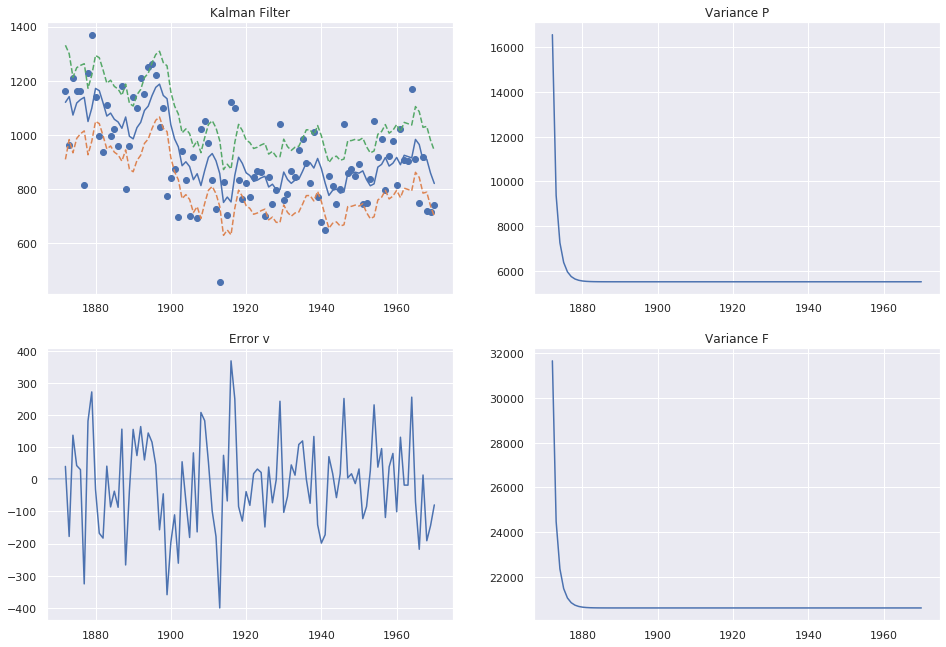

In [380]:
x_axis = range(base_year+1, end_year)
plot_quadrant(filtered, x_axis,
              datapoints=data[1:],
              titles=["Kalman Filter", "Variance P", "Error v", "Variance F"])

### State Smoothing

Another approach one could take is smoothing. This entails using forward looking data, hence it is a procedure of interpolation, compared to the extrapolation used above.

We first compute, in `cumulative_smoothings`, the forward looking $r$ and $N$, that capture future information (weighting) of the state and the variance respectively.

Then one can update the state variable $a_{t+1}(r_{t})$ and variance $V_{t+1}(N_{t})$.

Below plotted the smoothed state and variance. One can notice the increased "smoothness" and the variance, which is in the steady state only outside of the extreme. Clearly the variance has this peculiar shape because for small values of $t$, one misses previous values to compute $a_t$, and for larger $t$ one misses future values to compute $r_t$

In [381]:
def cumulative_smoothings(v, F, P):
    n = len(v)
    L = 1 - P/F
    r = np.zeros(n + 1)
    N = np.zeros(n + 1)

    
    for t in reversed(range(1, n)):
        
        r[t] = v[t]/F[t] + L[t] * r[t + 1]
        N[t] = 1/F[t] + np.square(L[t]) * N[t + 1]
        
    return r[:-1], N[:-1]

def KF_smoothing(series, *kf_args, **kf_kwargs):
    
    filtered = KF(series, *kf_args, **kf_kwargs)
    v, F = filtered[:, 2], filtered[:, 3]
    a, P = filtered[:, 0], filtered[:, 1]

    r, N = cumulative_smoothings(v, F, P)
        
    smoothed_state = a + P*r
    smoothed_var = P - np.square(P) * N
    
    smoothed = np.column_stack([smoothed_state, smoothed_var, r, N]) 
    
    return smoothed

### Figure 2.2

In [382]:
smoothed = KF_smoothing(data, **init, **params)

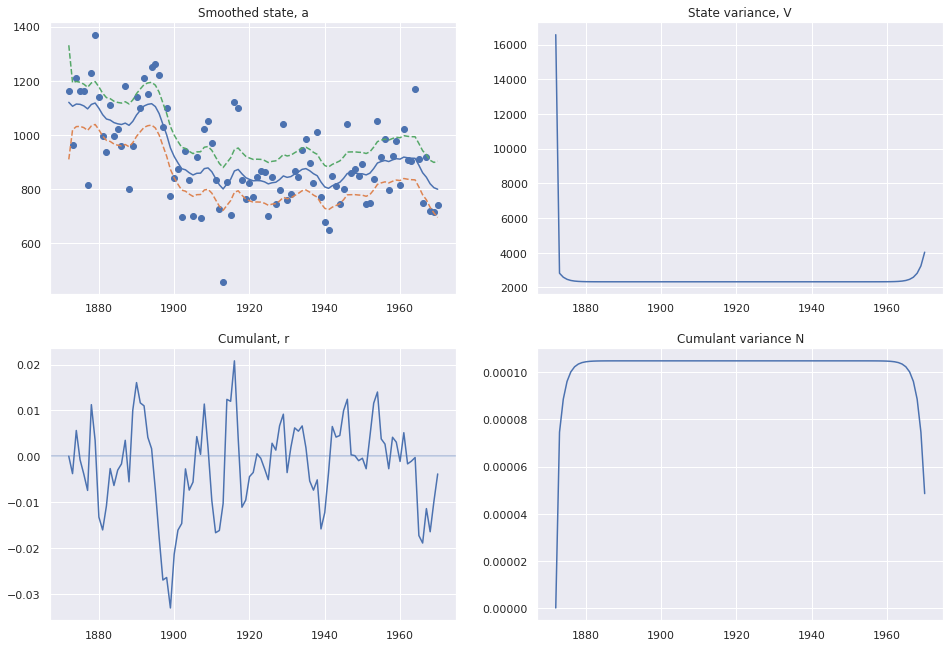

In [383]:
ts = ["Smoothed state, a", "State variance, V", "Cumulant, r", "Cumulant variance N"]
plot_quadrant(smoothed, x_axis,
              datapoints=data[1:], ci=True,
              titles=ts)

### Figure 2.3

In [384]:
def observation_disturbance(series, *kf_args, **kf_kwargs):
    filtered, var_eps, var_eta = max_likelihood_KF(series, *kf_args, **kf_kwargs)
    v, F = filtered[:, 2], filtered[:, 3]
    a, P = filtered[:, 0], filtered[:, 1]
    
    r, N = cumulative_smoothings(v, F, P)
    
    K = P/F
    u = v/F - r*K
    D = 1/F + np.square(K)*N
    
    eps = var_eps*u
    V_eps = var_eps - np.square(var_eps)*D
    
    eta = var_eta*r
    V_eta = var_eta - np.square(var_eta)*N
    
    u_hat = np.divide(u, np.sqrt(D), out=np.zeros_like(u))
    r_hat = np.divide(r, np.sqrt(N), out=np.zeros_like(r))
    
    return np.column_stack([eps, np.sqrt(V_eps), eta, np.sqrt(V_eta), u_hat, r_hat]) 

In [385]:
disturbance = observation_disturbance(data, **init, **params)

/home/nofishlikeian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


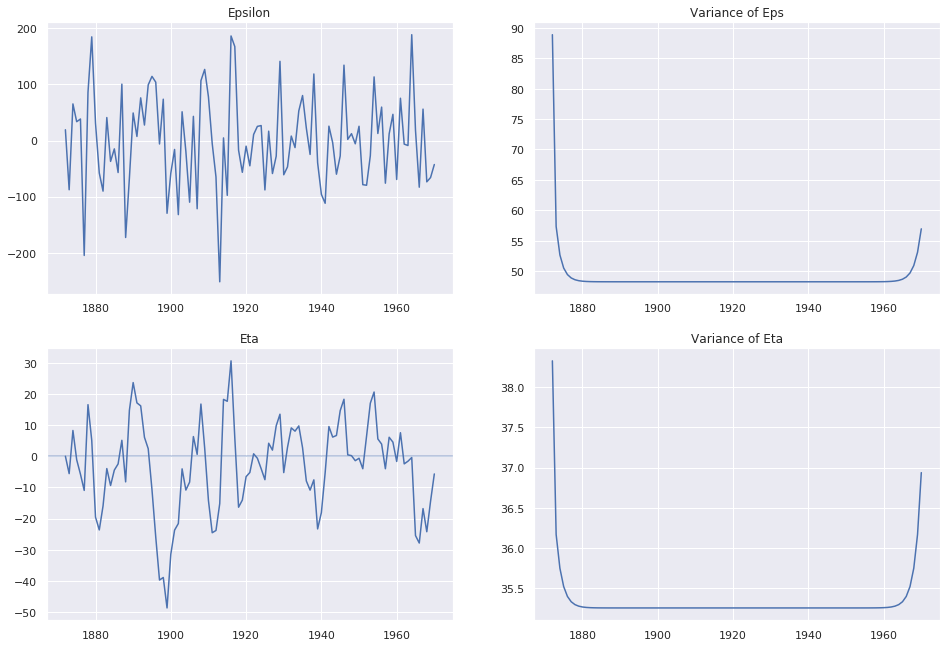

In [386]:
ts = ["Epsilon", "Variance of Eps", "Eta", "Variance of Eta"]
plot_quadrant(disturbance, x_axis, ci=False,
              titles=ts)

### Figure 2.5

To approach missing data, both in smoothing and forecasting, we can use the exact same `step` function as before, since, a missing $y$ simply yields an unknown $v$, which in turn implies a variance $P \xrightarrow{} \infty$. This is consistent and dealt with within the standard theory. This can be clearly seen in the plot of variances. The variance $P$ increases linearly at every time step by $\sigma^2_{\eta}$, and as soon as new data comes in converges again to the steady state.

In [387]:
missing_series = data.copy()
missing_series[21: 41] = np.nan
missing_series[61: 81] = np.nan

In [388]:
interp = KF(missing_series, **init, **params)

In [389]:
smoothed = KF_smoothing(missing_series, **init, **params)

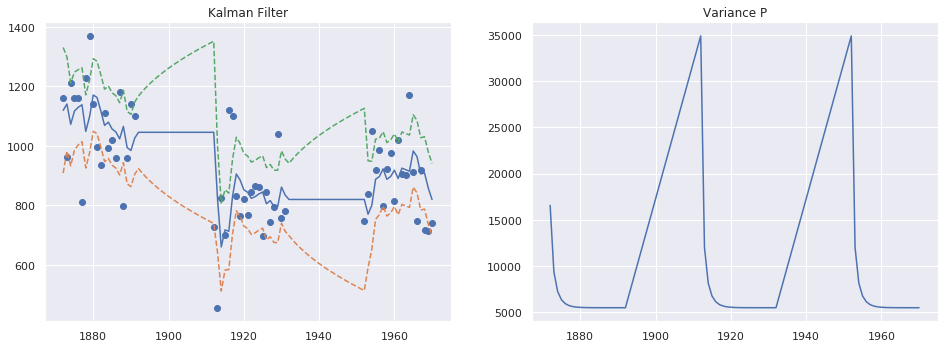

In [390]:
plot_quadrant(interp, x_axis,
              datapoints=missing_series[1:],
              ci=True,
              only_first=True,
              titles=["Kalman Filter", "Variance P"])

The same applies to smoothing. The main difference is that in this case one can "borrow" future information, hence the variance would smoothly and symmetricly diverge from the steady state around the data.

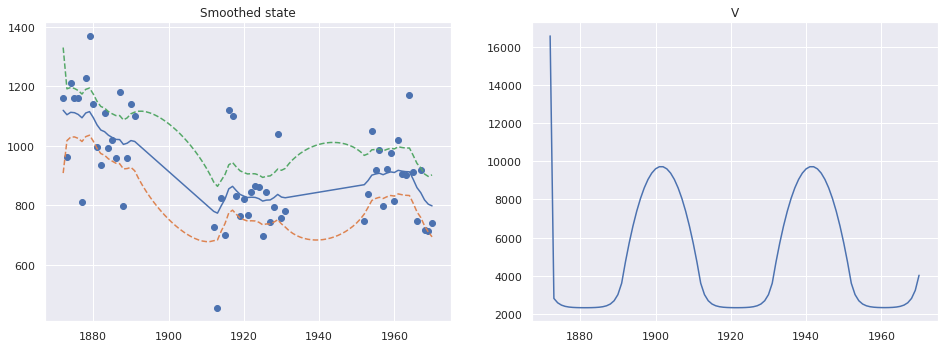

In [391]:
plot_quadrant(smoothed, x_axis,
              datapoints=missing_series[1:],
              ci=True,
              only_first=True,
              titles=["Smoothed state", "V"])

### Figure 2.6

The forecast is dealt with in the same manner as missing observations. Clearly one cannot interpolate but only extrapolate in this case. 

In [392]:
forward = np.nan*np.ones(30)
forecast_data = np.append(data, forward)
interp_axis = range(base_year + 1, base_year + len(forecast_data))

In [393]:
extrap, _, _ = max_likelihood_KF(forecast_data, **init, **params, verbose=True)

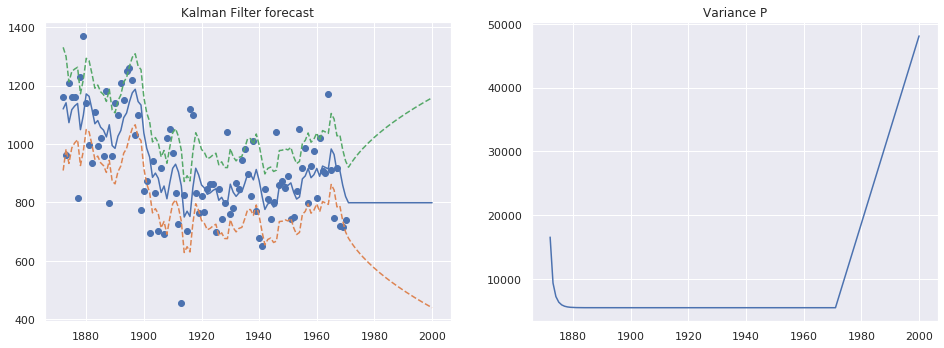

In [394]:
plot_quadrant(extrap, interp_axis,
              datapoints=forecast_data[1:],
              ci=True,
              only_first=True,
              titles=["Kalman Filter forecast", "Variance P"])

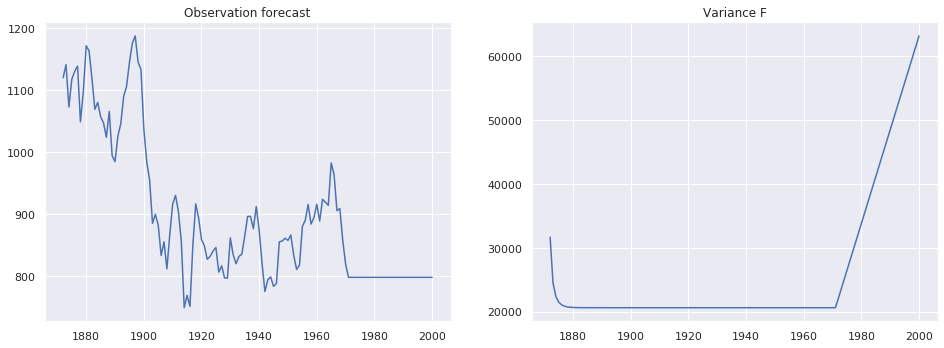

In [398]:
forecast = extrap[:, [0, 1]]
forecast[:, 1] += params["var_eps"]
plot_quadrant(forecast, interp_axis,
              ci=False,
              only_first=True,
              titles=["Observation forecast", "Variance F"])

### Figure 2.7

In order to assess whether, under the local level model, the assumptions of normality of $\epsilon_t$ and $\eta_t$, we can check the distribution of the standardised residuals 

\begin{align*}
    e_t = \frac{v_t}{\sqrt{F_t}}
\end{align*}

From the plot we can see that the distribution is similar to a normal and that the residuals are not autocorrelated.

In [399]:
from scipy.stats import norm

In [400]:
def quantiles(data):
    n = len(data)
    s_data = np.sort(data)
    quantile = norm.ppf((np.arange(1, len(s_data)+1) - 0.5) / n)
    
    return s_data, quantile
    
    
def autocorrelation(data, hs=10):
    Y = data - np.mean(data)
    var = Y@Y
    corr = np.zeros(hs)
    bins = list(range(1, hs+1))
    
    for h in bins:
        prev = Y[h:]@Y[:-h]
        corr[h-1] = prev
        
        
    return corr/var, bins 

In [401]:
def plot_diagnostics(v, F, xs):
    errors = v/np.sqrt(F)
    s_data, quantile = quantiles(errors)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = a_size)
    
    ax1.plot(xs, errors)
    ax1.axhline(0, alpha=0.4)
    
    sns.distplot(errors, ax=ax2)
    
    lims = [-2.4, 2.4]
    ax3.set_xlim(lims)
    ax3.set_ylim(lims)
    
    ax3.plot(quantile, s_data)
    ax3.plot(ax3.get_xlim(), ax3.get_ylim(), ls="--", c=".3")
    
    rho, bins = autocorrelation(errors)
    ax4.set_ylim(-1,1)
    ax4.bar(bins, rho)
    
    plt.show()

In [402]:
filtered = KF(data, **init, **params)
v, F = filtered[:, 2], filtered[:, 3]

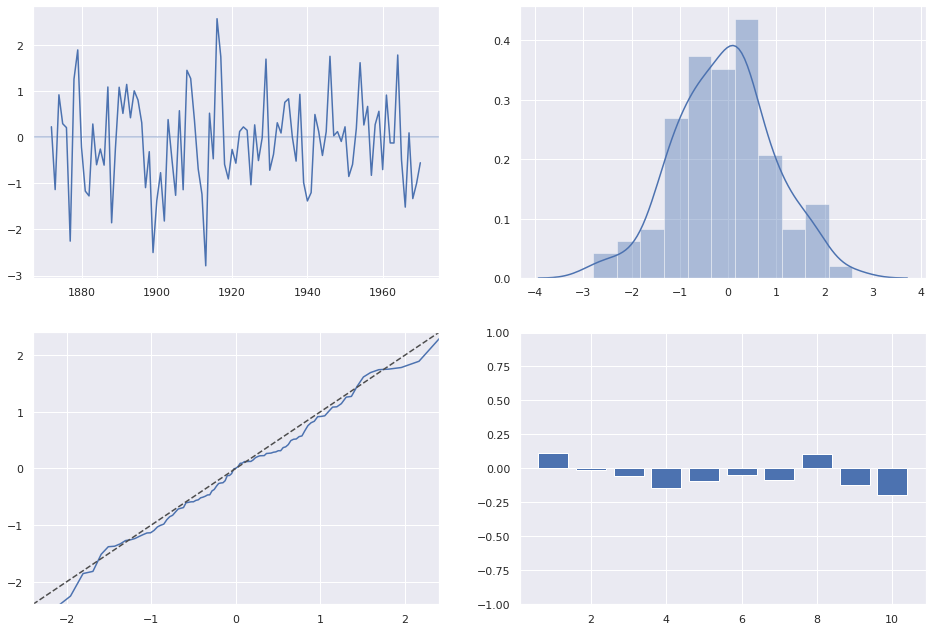

In [403]:
plot_diagnostics(v, F, x_axis)

### Figure 2.8

One can then plot 
\begin{align*}
    u^{*}_t &= D_t^{-1/2} u \\
    r^{*}_t &= N_t^{-1/2} r
\end{align*}

One can plot these values, and respective distribution, to spot outliers (with $u^{*}_t$) and structural breaks (with $r^{*}_t$)

In [404]:
dist_data = observation_disturbance(data, **init, **params)

def plot_structural(dist_data, xs):
    u_hat, r_hat = dist_data[:, 4], dist_data[:, 5]
    
    fig, rows = plt.subplots(2, 2, figsize = a_size)
    
    for i, res in enumerate((u_hat, r_hat)):
        
        rows[i][0].plot(xs, res)
        rows[i][0].axhline(0, alpha=0.4)
        
        sns.distplot(res[~np.isnan(res)], ax = rows[i][1], bins=13)

    plt.show()

/home/nofishlikeian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


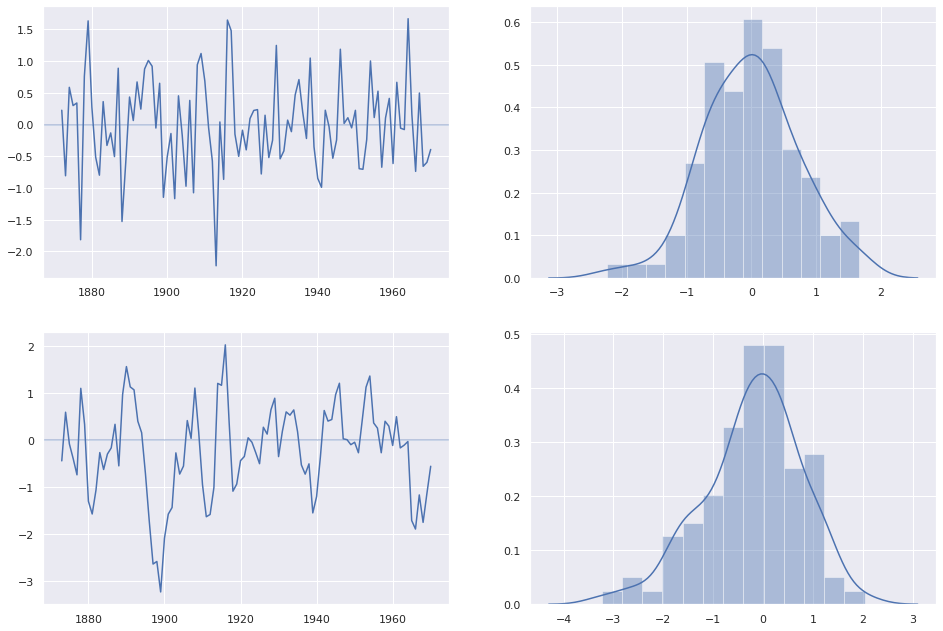

In [405]:
plot_structural(dist_data, x_axis)